---
title: Decision Trees
date: 2010-03-20
summary: "This dataset is used to predict whether or not an image contains signs of diabetetic retinopathy. The variables used are the quality assessment, pre-screening that outputs 1 for severe retinal abnormality and 0 for lack of abnormality, the results of MA detection, the euclidean distance of the center of the macula and the center of the optic disc, the diameter of the optic disc, the AM/FM-based classification, and the class label."

---

In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

%matplotlib inline

In [3]:
# Read the data from csv file
col_names = []
for i in range(20):
    if i == 0:
        col_names.append('quality')
    if i == 1:
        col_names.append('prescreen')
    if i >= 2 and i <= 7:
        col_names.append('ma' + str(i))
    if i >= 8 and i <= 15:
        col_names.append('exudate' + str(i))
    if i == 16:
        col_names.append('euDist')
    if i == 17:
        col_names.append('diameter')
    if i == 18:
        col_names.append('amfm_class')
    if i == 19:
        col_names.append('label')

data = pd.read_csv("messidor_features.txt", names = col_names)
print(data.shape)
data.head(10)

(1151, 20)


,quality,prescreen,ma2,ma3,ma4,ma5,ma6,ma7,exudate8,exudate9,exudate10,exudate11,exudate12,exudate13,exudate14,exudate15,euDist,diameter,amfm_class,label
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
5,1,1,44,43,41,41,37,29,28.356400,6.935636,2.305771,0.323724,0.000000,0.000000,0.000000,0.000000,0.502831,0.126741,0,1
6,1,0,29,29,29,27,25,16,15.448398,9.113819,1.633493,0.000000,0.000000,0.000000,0.000000,0.000000,0.541743,0.139575,0,1
7,1,1,6,6,6,6,2,1,20.679649,9.497786,1.223660,0.150382,0.000000,0.000000,0.000000,0.000000,0.576318,0.071071,1,0
8,1,1,22,21,18,15,13,10,66.691933,23.545543,6.151117,0.496372,0.000000,0.000000,0.000000,0.000000,0.500073,0.116793,0,1
9,1,1,79,75,73,71,64,47,22.141784,10.054384,0.874633,0.099780,0.023386,0.000000,0.000000,0.000000,0.560959,0.109134,0,1


### 1. Data preprocessing  & dimensionality reduction with PCA

In [4]:
# Separate the feature columns from the class label column
data_Y = data['label']
data_X = data.drop(['label'], axis = 1)

print(data_Y.shape)
print(data_X.shape)

(1151,)
(1151, 19)


In [5]:
# Standardize the the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_X)

print()
print(type(X_scaled))
print(X_scaled.shape)

# Make sure data got stored directly
print()
print(X_scaled[0])
print("mean", X_scaled.mean())
print("variance", X_scaled.std())




<class 'numpy.ndarray'>
(1151, 19)

[ 0.05905386  0.2982129  -0.6414863  -0.61878225 -0.57646257 -0.63002889
 -0.55111605 -0.47374452 -0.24291735 -0.24600298 -0.29696618 -0.2715091
 -0.21832427 -0.19440942 -0.20512449 -0.18616904 -1.29476283 -0.46865568
  1.40504812]
mean -2.8876256637559514e-17
variance 1.0


### 1. Splitting dataset into training and test sets (80% - 20% split). The number of records are in the training set and test set are displayed.

In [6]:
# Split data into a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data_Y, test_size = 0.20, random_state = None)
print("X_train=",X_train.shape, " y_train=", y_train.shape)
print("X_test=",X_test.shape, " y_test=", y_test.shape)

X_train= (920, 19)  y_train= (920,)
X_test= (231, 19)  y_test= (231,)


In [7]:
# Fit PCA to training set
pca = PCA()
pca_data = pca.fit_transform(X_train)

pca_data_df = pd.DataFrame(pca_data)
pca_data_df.head()

pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
var_exp = pca.explained_variance_ratio_
print("Variance in each PC:", var_exp)

cum_var_exp = np.cumsum(var_exp)
print("Cumulative variance:", cum_var_exp)

# Transform the test set
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

print (X_train_pca.shape, X_test_pca.shape)


Variance in each PC: [0.3409337  0.25534013 0.11637548 0.05955264 0.05336725 0.04494376
 0.04135008 0.03249032 0.02310684]
Cumulative variance: [0.3409337  0.59627383 0.71264932 0.77220196 0.8255692  0.87051296
 0.91186304 0.94435336 0.9674602 ]
(920, 9) (231, 9)


### 2. Training Decision Trees in `scikit-learn`

[Text(167.4, 190.26, 'X[1] <= 2.28\nentropy = 0.997\nsamples = 920\nvalue = [428, 492]'),
 Text(83.7, 135.9, 'X[0] <= 2.221\nentropy = 1.0\nsamples = 846\nvalue = [422, 424]'),
 Text(41.85, 81.53999999999999, 'X[8] <= -0.286\nentropy = 0.989\nsamples = 673\nvalue = [378, 295]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.956\nsamples = 130\nvalue = [49, 81]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 0.967\nsamples = 543\nvalue = [329, 214]'),
 Text(125.55000000000001, 81.53999999999999, 'X[6] <= -0.295\nentropy = 0.818\nsamples = 173\nvalue = [44, 129]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.959\nsamples = 21\nvalue = [13, 8]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.73\nsamples = 152\nvalue = [31, 121]'),
 Text(251.10000000000002, 135.9, 'X[0] <= -1.95\nentropy = 0.406\nsamples = 74\nvalue = [6, 68]'),
 Text(209.25, 81.53999999999999, 'X[8] <= -0.193\nentropy = 0.896\nsamples = 16\nvalue = [5, 11]'),
 Text(188.32500000000002, 27.180000000000007

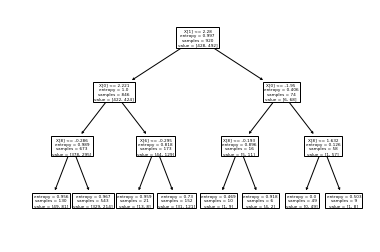

In [8]:
# Create a decision tree 
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
clf = clf.fit(X_train_pca, y_train)
tree.plot_tree(clf)

In [9]:
# Predict classes
pred_Y = clf.predict(X_test_pca)
print(pred_Y)

print(X_test)

# Print accuracy
print('Accuracy on test data is:', (accuracy_score(y_test, pred_Y)))


[1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1
 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 0 1 1 1]
[[ 0.05905386  0.2982129   1.23279764 ...  0.26957562 -0.96756708
  -0.7117194 ]
 [ 0.05905386  0.2982129   0.41279842 ...  1.23212748  0.27187848
  -0.7117194 ]
 [ 0.05905386  0.2982129   0.8813694  ... -1.43155196 -0.91477134
  -0.7117194 ]
 ...
 [ 0.05905386  0.2982129  -1.03196212 ...  1.07098304 -1.36083125
   1.40504812]
 [ 0.05905386  0.2982129   0.52994116 ...  0.90488195 -0.46274612
  -0.7117194 ]
 [ 0.05905386  0.2982129   2.95089125 ... -0.08042055 -0.61946083
  -0.7117194 ]]
Accuracy on test data is: 0.4978354978

### 3. Using K-fold Cross Validation

In [10]:
clf = tree.DecisionTreeClassifier()

# Run a 10-fold cross validation
scores = cross_val_score(clf, data_X, data_Y, cv=10) 
print("Scores:", scores)                                            

print("Accuracy:", scores.mean()*100)

Scores: [0.62068966 0.6173913  0.5826087  0.54782609 0.65217391 0.66086957
 0.65217391 0.57391304 0.66956522 0.56521739]
Accuracy: 61.42428785607197


In [11]:
clf = tree.DecisionTreeClassifier()

# Try max_depth values of 5, 10, 15, 20
params = {"max_depth": [5, 10, 15, 20], 
          "min_samples_leaf": [5, 10, 15, 20], 
          "max_features": [5, 10, 15]}


# Create the GridSearchCV object:
# Pass in classifier (the decision tree), the parameters to test, 5-fold cross validation
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')

# A 5-fold CV will be run for each max_depth and accuracy will be assesed for each max_depth
grid_search.fit(data_X, data_Y)

# Find best max_depth
print(grid_search.best_params_)
# Print accuracy for best max_depth?
print("Accuracy:", grid_search.best_score_*100)

{'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 20}
Accuracy: 64.29192006950478


In [12]:
# Perform the nested cross-validation
nested_score = cross_val_score(grid_search, data_X, data_Y, cv=3)

print("Accuracy:", nested_score.mean()*100)

/Users/piacadar/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy: 61.07892732811141
